# 0.Import modules

In [48]:
import sys
import os
from pathlib import Path

import gc
import warnings

from datetime import datetime
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as se
import scipy.stats as stats
from tqdm import tqdm

from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor


In [49]:

# Set view options
se.set(style='white', context='notebook', rc={'figure.figsize': (14, 10)})

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

warnings.filterwarnings('ignore')

%matplotlib inline

#   1.Business Understanding

In Kaggle's GoDaddy Microbusiness Density Forecasting competition, we are given 3135 time series of length 39. These time series are 39 month observations from 3135 unique USA counties between the months of August 2019 thru October 2022 inclusive. We are asked to predict microbusiness density for the next 8 months which are November 2022 thru June 2023 inclusive. Microbusiness density is the number of microbusinesses per 100 adults in specific county. We are asked to make 25080 predictions = 3135 * 8 and the public LB is the evaluation of 3135 predictions for the most recent month using SMAPE metric. The private LB is the evaluation of predictions after current month.


# 2.Load data

1. train.csv - the training set

    1.1 row_id - An ID code for the row.

    1.2 cfips - A unique identifier for each county using the Federal Information Processing System. The first two digits correspond to the state FIPS code, while the following 3 represent the county.

    1.3 county_name - The written name of the county.

    1.4 state_name - The name of the state.

    1.5 first_day_of_month - The date of the first day of the month.

    1.6 microbusiness_density - Microbusinesses per 100 people over the age of 18 in the given county. This is the target variable. The population figures used to calculate the density are on a two-year lag due to the pace of update provided by the U.S. Census Bureau, which provides the underlying population data annually. 2021 density figures are calculated using 2019 population figures, etc.
    
    1.7 active - The raw count of microbusinesses in the county. Not provided for the test set.

2. revealed_test.csv - the new part of train set. The same scheme as train.csv

3. census_starter.csv Examples of useful columns from the Census Bureau's American Community Survey (ACS) at data.census.gov. The percentage fields were derived from the raw counts provided by the ACS. All fields have a two year lag to match what information was avaiable at the time a given microbusiness data update was published.

    3.1 pct_bb_[year] - The percentage of households in the county with access to broadband of any type. Derived from ACS table B28002: PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD.

    3.2 cfips - The CFIPS code.

    3.3 pct_college_[year] - The percent of the population in the county over age 25 with a 4-year college degree. Derived from ACS table S1501: EDUCATIONAL ATTAINMENT.

    3.4 pct_foreign_born_[year] - The percent of the population in the county born outside of the United States. Derived from ACS table DP02: SELECTED SOCIAL CHARACTERISTICS IN THE UNITED STATES.

    3.5 pct_it_workers_[year] - The percent of the workforce in the county employed in information related industries. Derived from ACS table S2405: INDUSTRY BY OCCUPATION FOR THE CIVILIAN EMPLOYED POPULATION 16 YEARS AND OVER.
    3.6 median_hh_inc_[year] - The median household income in the county. Derived from ACS table S1901: INCOME IN THE PAST 12 MONTHS (IN 2021 INFLATION-ADJUSTED DOLLARS).

4. test.csv Metadata for the submission rows. This file will remain unchanged throughout the competition.

    4.1 row_id - An ID code for the row.

    4.2 cfips - A unique identifier for each county using the Federal Information Processing System. The first two digits correspond to the state FIPS code, while the following 3 represent the county.

    4.3 first_day_of_month - The date of the first day of the month.

5. sample_submission.csv A valid sample submission. This file will remain unchanged throughout the competition.

    5.1 row_id - An ID code for the row.
    
    5.2 microbusiness_density - The target variable.

In [50]:
#Paths
DATA_PATH = Path("../data")
DATA_PROCESSED_PATH = DATA_PATH / "processed"

In [51]:
train = pd.read_csv(DATA_PROCESSED_PATH / "train_mod.csv")

submission_template = pd.read_csv(DATA_PATH / "raw/test.csv")
census = pd.read_csv(DATA_PATH / "raw/census_starter.csv")
submission_example = pd.read_csv(DATA_PATH / "raw/sample_submission.csv")


train['ds'] = pd.to_datetime(train['first_day_of_month'])
train['year'] = train['ds'].dt.year
train['month'] = train['ds'].dt.month

In [52]:
submission_baseline = pd.read_csv('../notebooks/submission.csv')
submission_baseline.head()

row_id  microbusiness_density
0  1001_2022-11-01               3.404744
1  1001_2022-12-01               3.422746
2  1001_2023-01-01               3.337234
3  1001_2023-02-01               1.167919
4  1001_2023-03-01               1.167919

# 3 Model

In [53]:
# A bunch of useful functions
def from_active_to_density(submission):
    COLS = ["GEO_ID", "NAME", "S0101_C01_026E"]
    df2020 = pd.read_csv(
        DATA_PATH / "external/census/ACSST5Y2020.S0101-Data.csv", usecols=COLS
    )
    df2020 = df2020.iloc[1:]
    df2020["S0101_C01_026E"] = df2020["S0101_C01_026E"].astype("int")

    df2021 = pd.read_csv(
        DATA_PATH / "external/census/ACSST5Y2021.S0101-Data.csv", usecols=COLS
    )
    df2021 = df2021.iloc[1:]
    df2021["S0101_C01_026E"] = df2021["S0101_C01_026E"].astype("int")
    df2021.head()

    df2020["cfips"] = df2020.GEO_ID.apply(lambda x: int(x.split("US")[-1]))
    adult2020 = df2020.set_index("cfips").S0101_C01_026E.to_dict()

    df2021["cfips"] = df2021.GEO_ID.apply(lambda x: int(x.split("US")[-1]))
    adult2021 = df2021.set_index("cfips").S0101_C01_026E.to_dict()

    submission["adult2020"] = submission.cfips.map(adult2020)
    submission["adult2021"] = submission.cfips.map(adult2021)

    submission["microbusiness_density"] = (
        submission["microbusiness_density"].round() * 100 / submission["adult2021"]
    )

In [54]:
train.head()

row_id  cfips          county    state first_day_of_month  \
0  1001_2019-08-01   1001  Autauga County  Alabama         2019-08-01   
1  1001_2019-09-01   1001  Autauga County  Alabama         2019-09-01   
2  1001_2019-10-01   1001  Autauga County  Alabama         2019-10-01   
3  1001_2019-11-01   1001  Autauga County  Alabama         2019-11-01   
4  1001_2019-12-01   1001  Autauga County  Alabama         2019-12-01   

   microbusiness_density  active         ds  year  month          GEO_ID  \
0               2.856021    1249 2019-08-01  2019      8  0500000US01001   
1               2.884870    1198 2019-09-01  2019      9  0500000US01001   
2               3.055843    1269 2019-10-01  2019     10  0500000US01001   
3               2.993233    1243 2019-11-01  2019     11  0500000US01001   
4               2.993233    1243 2019-12-01  2019     12  0500000US01001   

              county_state  adult_population  dcount  county_i  state_i  \
0  Autauga County, Alabama             41527       0         0        0   
1  Autauga County, Alabama             41527       1         0        0   
2  Autauga County, Alabama             41527       2         0        0   
3  Autauga County, Alabama             41527       3         0        0   
4  Autauga County, Alabama             41527       4         0        0   

   mbd_lag_1       dif  
0   2.856021  0.000000  
1   2.856021  0.010101  
2   2.884870  0.059265  
3   3.055843  0.020489  
4   2.993233  0.000000

In [55]:
cfips_list = train['cfips'].unique()

In [56]:
prediction_df = pd.DataFrame()

for cfip in tqdm(cfips_list):
    train_data = TimeSeriesDataFrame.from_data_frame(
    train[train.cfips == cfip],
    id_column="cfips",
    timestamp_column="ds",
    )

    predictor = TimeSeriesPredictor(
    prediction_length=5,
    path="autogluon_v3_best_quality",
    target="active",
    eval_metric="sMAPE",
    )

    predictor.fit(
        train_data,
        presets="medium_quality",
        time_limit=600,
        verbosity=0,
    )

    predictions = predictor.predict(train_data)
    prediction_df = pd.concat([prediction_df, predictions])

  0%|          | 0/3135 [00:00<?, ?it/s]Warning: path already exists! This predictor may overwrite an existing predictor! path="autogluon_v3_best_quality"
================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Setting presets to: medium_quality
Fitting with arguments:
{'enable_ensemble': True,
 'evaluation_metric': 'sMAPE',
 'hyperparameter_tune_kwargs': None,
 'hyperparameters': 'medium_quality',
 'prediction_length': 5,
 'random_seed': None,
 'target': 'active',
 'time_limit': 600,
 'verbosity': 0}
Provided training data set with 41 rows, 1 items (item = single time series). Average time series length is 41.0.
Training artifacts will be saved to: /Users/Artem_Boltaev/Documents/EPAM Projects/4. Microbisuness_Density_Forecasting_Kaggle/source_code/microbisuness_density_forecasting_kaggle/notebooks/autogluon_v3_best_quality
No path specified. Models will be saved in: "AutogluonModels/ag-20230312_194715/"
ETS with seasonal = add requires seasonal_period > 

In [57]:
prediction_df.head(10)

mean           0.1           0.2           0.3  \
item_id timestamp                                                            
1001    2023-01-01   1477.786946   1444.898403   1456.188364   1464.329221   
        2023-02-01   1480.902325   1434.845848   1450.656091   1462.056388   
        2023-03-01   1484.017704   1427.803802   1447.100880   1461.015431   
        2023-04-01   1487.133083   1422.336270   1444.579685   1460.618752   
        2023-05-01   1490.248462   1417.879993   1442.722602   1460.635871   
1003    2023-01-01  14133.000000  13802.302267  13915.824007  13997.681168   
        2023-02-01  14133.000000  13665.322781  13825.866765  13941.630273   
        2023-03-01  14133.000000  13560.214725  13756.840146  13898.620908   
        2023-04-01  14133.000000  13471.604534  13698.648014  13862.362337   
        2023-05-01  14133.000000  13393.537389  13647.379717  13830.417894   

                             0.4           0.5           0.6           0.7  \
item_id timestamp                                                            
1001    2023-01-01   1471.285283   1477.786946   1484.288610   1491.244672   
        2023-02-01   1471.797522   1480.902325   1490.007129   1499.748263   
        2023-03-01   1472.904902   1484.017704   1495.130507   1507.019977   
        2023-04-01   1474.323544   1487.133083   1499.942622   1513.647414   
        2023-05-01   1475.942099   1490.248462   1504.554825   1519.861053   
1003    2023-01-01  14067.625094  14133.000000  14198.374906  14268.318832   
        2023-02-01  14040.545922  14133.000000  14225.454078  14324.369727   
        2023-03-01  14019.767342  14133.000000  14246.232658  14367.379092   
        2023-04-01  14002.250189  14133.000000  14263.749811  14403.637663   
        2023-05-01  13986.817267  14133.000000  14279.182733  14435.582106   

                             0.8           0.9  
item_id timestamp                               
1001    2023-01-01   1499.385528   1510.675490  
        2023-02-01   1511.148560   1526.958803  
        2023-03-01   1520.934528   1540.231607  
        2023-04-01   1529.686481   1551.929896  
        2023-05-01   1537.774322   1562.616931  
1003    2023-01-01  14350.175993  14463.697733  
        2023-02-01  14440.133235  14600.677219  
        2023-03-01  14509.159854  14705.785275  
        2023-04-01  14567.351986  14794.395466  
        2023-05-01  14618.620283  14872.462611

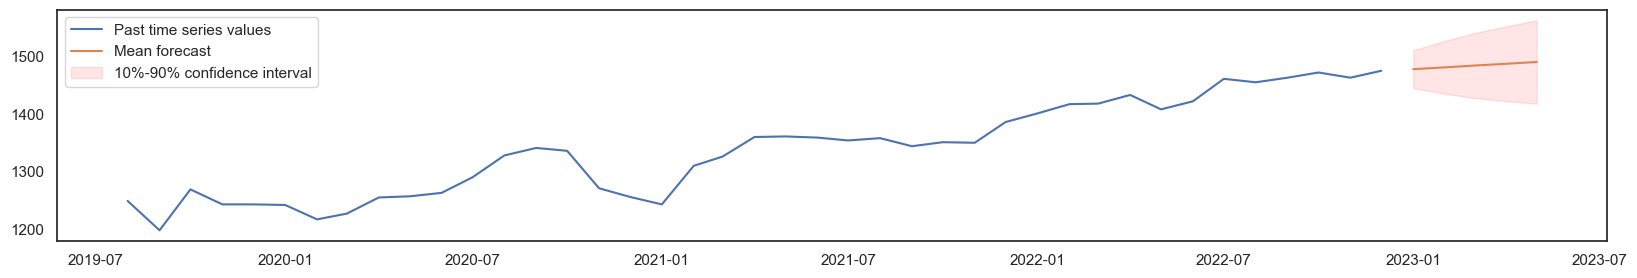

In [58]:
# Plot the predictions


plt.figure(figsize=(20, 3))

item_id = 1001
y_past = train[train.cfips == item_id]["active"].reset_index(drop=True)
x_past = train[train.cfips == item_id][["ds"]].reset_index(drop=True)

x_pred = prediction_df.loc[item_id].reset_index()[["timestamp"]]
y_pred = prediction_df.loc[item_id].reset_index()[["mean"]]

plt.plot(x_past, y_past, label="Past time series values")
plt.plot(x_pred, y_pred, label="Mean forecast")

plt.fill_between(
    prediction_df.loc[item_id].index,
    prediction_df.loc[item_id]["0.1"],
    prediction_df.loc[item_id]["0.9"],
    color="red",
    alpha=0.1,
    label=f"10%-90% confidence interval",
)
plt.legend()

# 4.Construct inference

inference from 2022-11-01 to 2023-05-01 <br>
2023-06-01 - not evaluate but need to predict

In [59]:
submission = submission_template.copy()
predictions = prediction_df.copy()

In [60]:
submission['first_day_of_month'] = pd.to_datetime(submission['first_day_of_month'])

In [61]:
predictions.reset_index(inplace=True)
predictions.rename(
    columns={"item_id": "cfips", "timestamp": "first_day_of_month"}, inplace=True
)
predictions.head()

cfips first_day_of_month         mean          0.1          0.2  \
0   1001         2023-01-01  1477.786946  1444.898403  1456.188364   
1   1001         2023-02-01  1480.902325  1434.845848  1450.656091   
2   1001         2023-03-01  1484.017704  1427.803802  1447.100880   
3   1001         2023-04-01  1487.133083  1422.336270  1444.579685   
4   1001         2023-05-01  1490.248462  1417.879993  1442.722602   

           0.3          0.4          0.5          0.6          0.7  \
0  1464.329221  1471.285283  1477.786946  1484.288610  1491.244672   
1  1462.056388  1471.797522  1480.902325  1490.007129  1499.748263   
2  1461.015431  1472.904902  1484.017704  1495.130507  1507.019977   
3  1460.618752  1474.323544  1487.133083  1499.942622  1513.647414   
4  1460.635871  1475.942099  1490.248462  1504.554825  1519.861053   

           0.8          0.9  
0  1499.385528  1510.675490  
1  1511.148560  1526.958803  
2  1520.934528  1540.231607  
3  1529.686481  1551.929896  
4  1537.774322  1562.616931

In [62]:
predictions['first_day_of_month'].max()

Timestamp('2023-05-01 00:00:00')

In [63]:
predictions['first_day_of_month'].min()

Timestamp('2023-01-01 00:00:00')

In [64]:
submission = submission.merge(
    predictions[["cfips", "first_day_of_month", "mean"]],
    on=["cfips", "first_day_of_month"],
    how="left",
)
submission.head()

row_id  cfips first_day_of_month  mean
0  1001_2022-11-01   1001         2022-11-01   NaN
1  1003_2022-11-01   1003         2022-11-01   NaN
2  1005_2022-11-01   1005         2022-11-01   NaN
3  1007_2022-11-01   1007         2022-11-01   NaN
4  1009_2022-11-01   1009         2022-11-01   NaN

In [65]:
submission.rename(columns={'mean': 'microbusiness_density'}, inplace=True)
from_active_to_density(submission)
submission.head()

row_id  cfips first_day_of_month  microbusiness_density  \
0  1001_2022-11-01   1001         2022-11-01                    NaN   
1  1003_2022-11-01   1003         2022-11-01                    NaN   
2  1005_2022-11-01   1005         2022-11-01                    NaN   
3  1007_2022-11-01   1007         2022-11-01                    NaN   
4  1009_2022-11-01   1009         2022-11-01                    NaN   

   adult2020  adult2021  
0      42496      44438  
1     171296     178105  
2      19804      19995  
3      17790      17800  
4      44383      45201

In [66]:
submission.dropna().head()

row_id  cfips first_day_of_month  microbusiness_density  \
6270  1001_2023-01-01   1001         2023-01-01               3.325982   
6271  1003_2023-01-01   1003         2023-01-01               7.935207   
6272  1005_2023-01-01   1005         2023-01-01               1.235309   
6273  1007_2023-01-01   1007         2023-01-01               1.286517   
6274  1009_2023-01-01   1009         2023-01-01               1.822969   

      adult2020  adult2021  
6270      42496      44438  
6271     171296     178105  
6272      19804      19995  
6273      17790      17800  
6274      44383      45201

In [67]:
submission.fillna(value=submission_baseline, inplace=True)
submission.head()

row_id  cfips first_day_of_month  microbusiness_density  \
0  1001_2022-11-01   1001         2022-11-01               3.404744   
1  1003_2022-11-01   1003         2022-11-01               3.422746   
2  1005_2022-11-01   1005         2022-11-01               3.337234   
3  1007_2022-11-01   1007         2022-11-01               1.167919   
4  1009_2022-11-01   1009         2022-11-01               1.167919   

   adult2020  adult2021  
0      42496      44438  
1     171296     178105  
2      19804      19995  
3      17790      17800  
4      44383      45201

In [68]:
submission[["row_id", "microbusiness_density"]].to_csv(
    DATA_PATH / "processed/submission_autogluon_v4_round.csv", index=False
)